# Deep Autoencoder on MNIST Dataset

<img src="https://4.bp.blogspot.com/-oUcusrWxk2U/WkntSbY7EQI/AAAAAAAAXHM/SzJ7vLUDu4U0IV5QfxQj-6W78h6-JUfSwCLcBGAs/s1600/4110_2.PNG" width="500" height="300">

Autoencoder is useful in extracting latent representation of high dimensional data, and with latent space visualization, we can see how the original data is distributed with new learned features. Most importantly for my case, not with this dataset though, but with the images I'm currently working on at my company, this technique could be used to detect anomalies if together we implement clustering or other outlier techniques such as isolation forest or local outlier factor.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())

from tensorflow import set_random_seed
set_random_seed(2)

import sys
sys.path.append('util/')
from util import plotProgress

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(60000,-1)
X_test = X_test.reshape(10000,-1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [4]:
# from sklearn.manifold import TSNE
# X_tsne=X_test[:5000].reshape(5000,-1)
# tsne=TSNE(n_components=2,verbose=1,n_iter=500).fit_transform(X_tsne)
# cmap=['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
# fig,ax=plt.subplots()
# for i in range(10):
#     ax.scatter(tsne[y_test[:5000]==i,0],tsne[y_test[:5000]==i,1],
#                 edgecolors='black',c=cmap[i],
#                 label=str(i))
#     ax.annotate(str(i),(tsne[y_test[:5000]==i,0].mean(),tsne[y_test[:5000]==i,1].mean()),
#                bbox=dict(boxstyle="round", fc="w"))
# plt.legend()

In [5]:
epochs = 100
batch = 256
latent_dim = 2
inter_dim1 = 400
# inter_dim2 = 128
# inter_dim3 = 200
# inter_dim4 = 32
# inter_dim5 = 50
optimizer = 'adam'

In [6]:
inputs=Input(shape = (X_train.shape[1],))
x = inputs
x = Dense(inter_dim1,activation='relu')(x)
# x = Dense(inter_dim2,activation='relu')(x)
# x = Dense(inter_dim3,activation='relu')(x)
# x = Dense(inter_dim4,activation='relu')(x)
# x = Dense(inter_dim5,activation='relu')(x)
# latent = Dense(latent_dim)(x)
encoder = Model(inputs,x,name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               314000    
Total params: 314,000
Trainable params: 314,000
Non-trainable params: 0
_________________________________________________________________


In [9]:
decode_in = Input(shape = (inter_dim1,))
decode = decode_in
# decode = Dense(inter_dim5,activation = 'relu')(decode)
# decode = Dense(inter_dim4,activation = 'relu')(decode)
# decode = Dense(inter_dim3,activation = 'relu')(decode)
# decode = Dense(inter_dim2,activation = 'relu')(decode)
decode = Dense(inter_dim1,activation = 'relu')(decode)
decode = Dense(X_train.shape[1],activation = 'sigmoid')(decode)
decoder = Model(decode_in,decode)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               314384    
Total params: 474,784
Trainable params: 474,784
Non-trainable params: 0
_________________________________________________________________


In [10]:
autoencoder = Model(inputs,decoder(encoder(inputs)))
autoencoder.compile(optimizer = optimizer,loss = 'mse')

In [11]:
es_cb = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = autoencoder.fit(X_train,X_train,
                        epochs = epochs,
                        batch_size = batch,
                        validation_data = (X_test,X_test),
                        callbacks=[es_cb])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 26us/step - loss: 0.0417 - val_loss: 0.0203
Epoch 2/100
60000/60000 [==============================] - 1s 19us/step - loss: 0.0178 - val_loss: 0.0149
Epoch 3/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.0141 - val_loss: 0.0123
Epoch 4/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.0119 - val_loss: 0.0107
Epoch 5/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.0107 - val_loss: 0.0099
Epoch 6/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.0099 - val_loss: 0.0091
Epoch 7/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.0091 - val_loss: 0.0086
Epoch 8/100
60000/60000 [==============================] - 1s 13us/step - loss: 0.0086 - val_loss: 0.0080
Epoch 9/100
60000/60000 [==============================] - 1s 12us/step - loss: 0.0083 - val_loss: 0.0

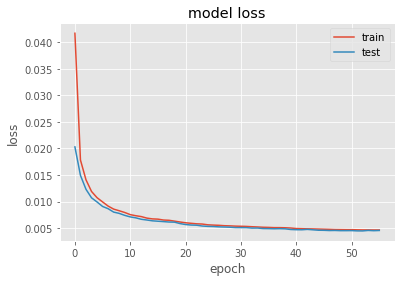

In [12]:
plotProgress(history)

In [13]:
# get latent variables
lat = encoder.predict(X_test)
# # plot scatter
# cmap = ['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
# fig,ax=plt.subplots(figsize = (10,8))
# for i in range(10):
#     ax.scatter(lat[y_test == i,0],lat[y_test == i,1],
#                edgecolors = 'black',
#                c = cmap[i],
#                label = str(i),
#                s=100)
#     ax.annotate(str(i),(lat[y_test == i,0].mean(),lat[y_test == i,1].mean()),
#                bbox = dict(boxstyle = "round", fc = "w"))
# plt.legend()

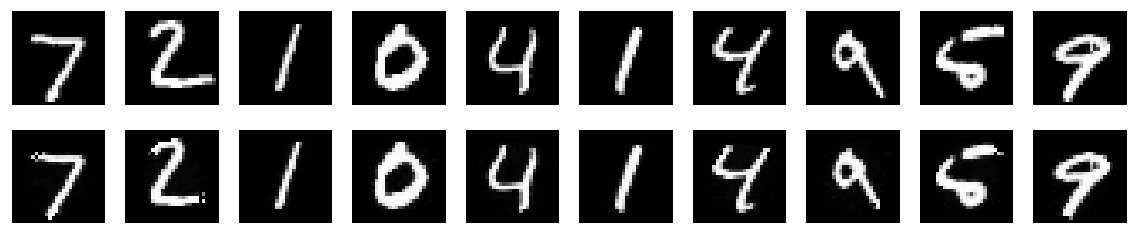

In [14]:
# get decoded digits
reconstructed = decoder.predict(lat)
# plot decoded
n = 10
row = 0
plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i + row * n].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()